# TensorFlow Probability: Forecasting Air Passenger Numbers with Structural Time Series Modelling

### Attributions

The below code uses the template from the [Structural Time Series modeling in TensorFlow Probability](https://blog.tensorflow.org/2019/03/structural-time-series-modeling-in.html) tutorial, of which the original authors **(Copyright 2019 The TensorFlow Authors)** have made available under the Apache 2.0 license.

Modifications have been made to the below code for the purpose of generating appropriate analyses on air passenger data from San Francisco Open Data - the original Jupyter Notebook used Atmospheric CO2 and Electricity Demand for modelling purposes. The original source code can be found [here](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Structural_Time_Series_Modeling_Case_Studies_Atmospheric_CO2_and_Electricity_Demand.ipynb).

The dataset for this example was extracted from the full dataset for air traffic passenger statistics from [DataSF](https://data.sfgov.org/Transportation/Air-Traffic-Passenger-Statistics/rkru-6vcg).

The below work and findings are not endorsed by the original authors in any way.

#### Apache 2.0 License

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

### Import Libraries

In [2]:
#@title Import and set ups{ display-mode: "form" }

%matplotlib inline
import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import acf, pacf

import collections

import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

tf.enable_v2_behavior()

### Plotting setup

Helper methods for plotting time series and forecasts.

In [3]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

sns.set_context("notebook", font_scale=1.)
sns.set_style("whitegrid")
%config InlineBackend.figure_format = 'retina'

### Load Data

In [4]:
import csv
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf

from math import sqrt
from numpy.random import seed
seed(1)
from pandas import DataFrame
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM

dtypes = {
        'Adjusted Passenger Count': 'float64'
}

In [5]:
dataset = pd.read_csv("british airways.csv", dtype=dtypes)

In [6]:
a=dataset.head()
b=dataset
b

Date  Adjusted Passenger Count
0    2005-07-01                   21686.0
1    2005-08-01                   20084.0
2    2005-09-01                   20635.0
3    2005-10-01                   18988.0
4    2005-11-01                   15554.0
..          ...                       ...
124  2015-11-01                   19800.0
125  2015-12-01                   17560.0
126  2016-01-01                   18397.0
127  2016-02-01                   16230.0
128  2016-03-01                   18392.0

[129 rows x 2 columns]

In [7]:
tseries=dataset['Adjusted Passenger Count']
tseries

0      21686.0
1      20084.0
2      20635.0
3      18988.0
4      15554.0
        ...   
124    19800.0
125    17560.0
126    18397.0
127    16230.0
128    18392.0
Name: Adjusted Passenger Count, Length: 129, dtype: float64

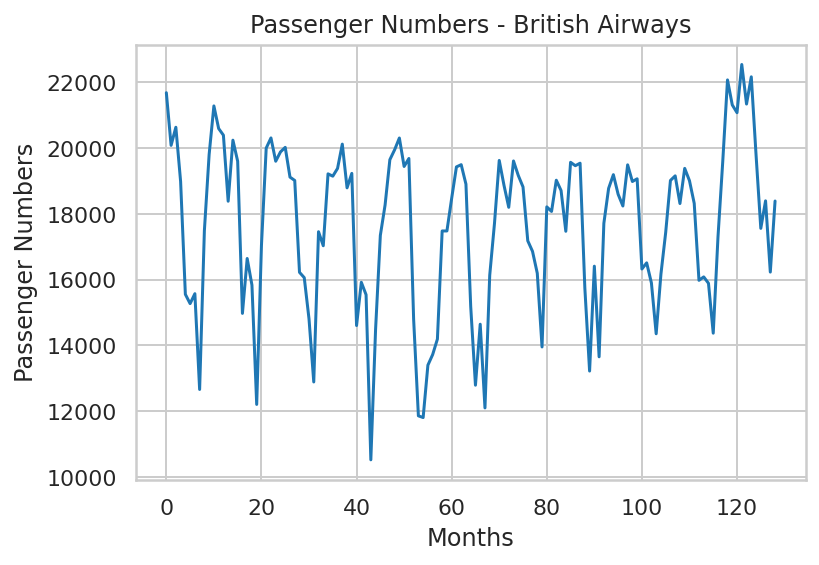

In [8]:
plt.plot(tseries)
plt.xlabel("Months")
plt.ylabel("Passenger Numbers")
plt.title("Passenger Numbers - British Airways")
plt.show()

In [9]:
type(tseries)

pandas.core.series.Series

In [10]:
def plot_forecast(x, y,
                  forecast_mean, forecast_scale, forecast_samples,
                  title, x_locator=None, x_formatter=None):
  """Plot a forecast distribution against the 'true' time series."""
  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]
  fig = plt.figure(figsize=(12, 6))
  ax = fig.add_subplot(1, 1, 1)

  num_steps = len(y)
  num_steps_forecast = forecast_mean.shape[-1]
  num_steps_train = num_steps - num_steps_forecast


  ax.plot(x, y, lw=2, color=c1, label='ground truth')

  forecast_steps = np.arange(
      x[num_steps_train],
      x[num_steps_train]+num_steps_forecast,
      dtype=x.dtype)

  ax.plot(forecast_steps, forecast_samples.T, lw=1, color=c2, alpha=0.1)

  ax.plot(forecast_steps, forecast_mean, lw=2, ls='--', color=c2,
           label='forecast')
  ax.fill_between(forecast_steps,
                   forecast_mean-2*forecast_scale,
                   forecast_mean+2*forecast_scale, color=c2, alpha=0.2)

  ymin, ymax = min(np.min(forecast_samples), np.min(y)), max(np.max(forecast_samples), np.max(y))
  yrange = ymax-ymin
  ax.set_ylim([ymin - yrange*0.1, ymax + yrange*0.1])
  ax.set_title("{}".format(title))
  ax.legend()

  if x_locator is not None:
    ax.xaxis.set_major_locator(x_locator)
    ax.xaxis.set_major_formatter(x_formatter)
    fig.autofmt_xdate()

  return fig, ax

In [11]:
def plot_components(dates,
                    component_means_dict,
                    component_stddevs_dict,
                    x_locator=None,
                    x_formatter=None):
  """Plot the contributions of posterior components in a single figure."""
  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]

  axes_dict = collections.OrderedDict()
  num_components = len(component_means_dict)
  fig = plt.figure(figsize=(12, 2.5 * num_components))
  for i, component_name in enumerate(component_means_dict.keys()):
    component_mean = component_means_dict[component_name]
    component_stddev = component_stddevs_dict[component_name]

    ax = fig.add_subplot(num_components,1,1+i)
    ax.plot(dates, component_mean, lw=2)
    ax.fill_between(dates,
                     component_mean-2*component_stddev,
                     component_mean+2*component_stddev,
                     color=c2, alpha=0.5)
    ax.set_title(component_name)
    if x_locator is not None:
      ax.xaxis.set_major_locator(x_locator)
      ax.xaxis.set_major_formatter(x_formatter)
    axes_dict[component_name] = ax
  fig.autofmt_xdate()
  fig.tight_layout()
  return fig, axes_dict

In [12]:
def plot_one_step_predictive(dates, observed_time_series,
                             one_step_mean, one_step_scale,
                             x_locator=None, x_formatter=None):
  """Plot a time series against a model's one-step predictions."""

  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]

  fig=plt.figure(figsize=(12, 6))
  ax = fig.add_subplot(1,1,1)
  num_timesteps = one_step_mean.shape[-1]
  ax.plot(dates, observed_time_series, label="observed time series", color=c1)
  ax.plot(dates, one_step_mean, label="one-step prediction", color=c2)
  ax.fill_between(dates,
                  one_step_mean - one_step_scale,
                  one_step_mean + one_step_scale,
                  alpha=0.1, color=c2)
  ax.legend()

  if x_locator is not None:
    ax.xaxis.set_major_locator(x_locator)
    ax.xaxis.set_major_formatter(x_formatter)
    fig.autofmt_xdate()
  fig.tight_layout()
  return fig, ax

## Training and Test Data

A model is fit to split the series into training and test data on a weekly basis.

### Data

In [13]:
num_forecast_steps = 1 * 12
tseries_training_data = tseries[:-num_forecast_steps]

tseries_dates = np.arange("2005-07-01", "2016-04-01", dtype="datetime64[M]")
tseries_loc = mdates.YearLocator(3)
tseries_fmt = mdates.DateFormatter('%Y')

In [14]:
tseries_dates

array(['2005-07', '2005-08', '2005-09', '2005-10', '2005-11', '2005-12',
       '2006-01', '2006-02', '2006-03', '2006-04', '2006-05', '2006-06',
       '2006-07', '2006-08', '2006-09', '2006-10', '2006-11', '2006-12',
       '2007-01', '2007-02', '2007-03', '2007-04', '2007-05', '2007-06',
       '2007-07', '2007-08', '2007-09', '2007-10', '2007-11', '2007-12',
       '2008-01', '2008-02', '2008-03', '2008-04', '2008-05', '2008-06',
       '2008-07', '2008-08', '2008-09', '2008-10', '2008-11', '2008-12',
       '2009-01', '2009-02', '2009-03', '2009-04', '2009-05', '2009-06',
       '2009-07', '2009-08', '2009-09', '2009-10', '2009-11', '2009-12',
       '2010-01', '2010-02', '2010-03', '2010-04', '2010-05', '2010-06',
       '2010-07', '2010-08', '2010-09', '2010-10', '2010-11', '2010-12',
       '2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06',
       '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12',
       '2012-01', '2012-02', '2012-03', '2012-04', 

In [15]:
tseries_training_data

0      21686.0
1      20084.0
2      20635.0
3      18988.0
4      15554.0
        ...   
112    15979.0
113    16084.0
114    15889.0
115    14372.0
116    17304.0
Name: Adjusted Passenger Count, Length: 117, dtype: float64

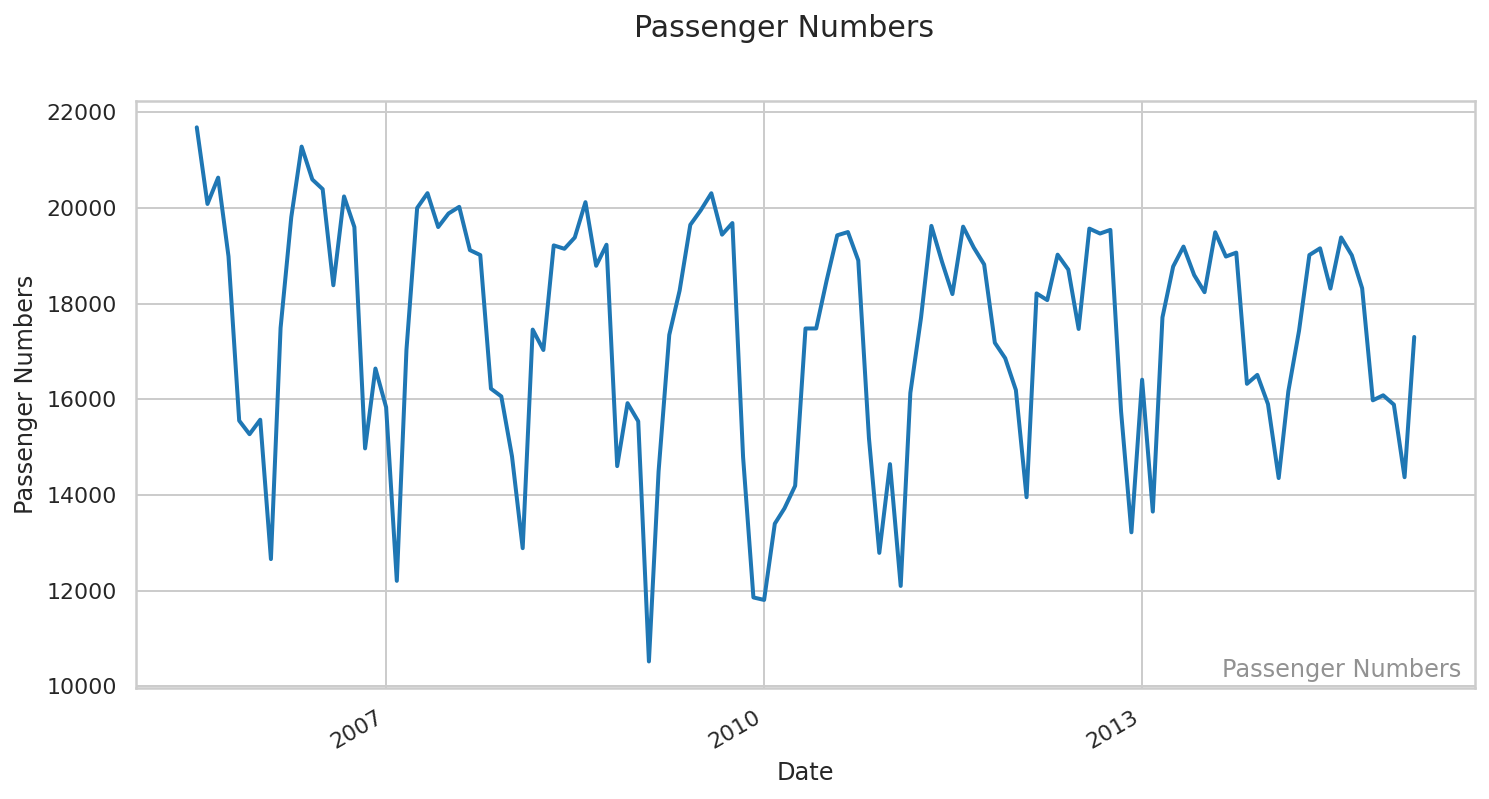

In [16]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(tseries_dates[:-num_forecast_steps], tseries_training_data, lw=2, label="training data")
ax.xaxis.set_major_locator(tseries_loc)
ax.xaxis.set_major_formatter(tseries_fmt)
ax.set_ylabel("Passenger Numbers")
ax.set_xlabel("Date")
fig.suptitle("Passenger Numbers",
             fontsize=15)
ax.text(0.99, .02,
        "Passenger Numbers",
        transform=ax.transAxes,
        horizontalalignment="right",
        alpha=0.5)
fig.autofmt_xdate()

In [17]:
type(tseries_dates[:-num_forecast_steps])

numpy.ndarray

In [18]:
tseries_training_data

0      21686.0
1      20084.0
2      20635.0
3      18988.0
4      15554.0
        ...   
112    15979.0
113    16084.0
114    15889.0
115    14372.0
116    17304.0
Name: Adjusted Passenger Count, Length: 117, dtype: float64

In [19]:
type(tseries_training_data)

pandas.core.series.Series

### Model and Fitting

The model is fitted with a local linear trend, along with a monthly seasonal effect (num_seasons=12).

In [20]:
def build_model(observed_time_series):
  trend = sts.LocalLinearTrend(observed_time_series=observed_time_series)
  seasonal = tfp.sts.Seasonal(
      num_seasons=12, observed_time_series=observed_time_series)
  residual_level = tfp.sts.Autoregressive(
      order=1,
      observed_time_series=observed_time_series, name='residual')
  autoregressive = sts.Autoregressive(
      order=1,
      observed_time_series=observed_time_series,
      name='autoregressive')
  model = sts.Sum([trend, seasonal, residual_level, autoregressive], observed_time_series=observed_time_series)
  return model

### Variational Inference

The model is fit using variational inference, which is a means of approximating posterior densities for Bayesian models - this is an alternative to the Markov Chain Monte Carlo (MCMC) sampling that you will have encountered in Project 3.

You can find more information about variational inference from the following resources:

* [Blei, Kucukelbir, McAuliffe (2018): Variational Inference: A Review for Statisticians](https://sgfin.github.io/files/notes/blei_variational_review.pdf)

* [TensorFlow Probability: Structural Time Series modeling in TensorFlow Probability](https://blog.tensorflow.org/2019/03/structural-time-series-modeling-in.html)

In [21]:
tseries_model = build_model(tseries_training_data)

# Build the variational surrogate posteriors `qs`.
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(
    model=tseries_model)

Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.
Instructions for updating:
Do not call `graph_parents`.
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


In [22]:
#@title Minimize the variational loss.

# Allow external control of optimization to reduce test runtimes.
num_variational_steps = 200 # @param { isTemplate: true}
num_variational_steps = int(num_variational_steps)

optimizer = tf.optimizers.Adam(learning_rate=.1)
# Using fit_surrogate_posterior to build and optimize the variational loss function.
@tf.function(experimental_compile=True)
def train():
  elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=tseries_model.joint_log_prob(
        observed_time_series=tseries_training_data),
    surrogate_posterior=variational_posteriors,
    optimizer=optimizer,
    num_steps=num_variational_steps)
  return elbo_loss_curve

elbo_loss_curve = train()

plt.plot(elbo_loss_curve)
plt.title("Loss curve")
plt.show()

# Draw samples from the variational posterior.
q_samples_tseries_ = variational_posteriors.sample(50)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Instructions for updating:
Previously, `initial_step` would return the value passed to the constructor, even if that value was not `Tensor`-like. This behavior is now deprecated. In the future, it will always return a `Tensor`-like object.


In [23]:
q_samples_tseries_

OrderedDict([('observation_noise_scale',
              <tf.Tensor: shape=(50,), dtype=float64, numpy=
              array([455.70548814, 307.62506329, 375.71046711, 475.09344004,
                     448.15290239, 411.49241801, 338.66682951, 532.5119118 ,
                     280.40598412, 307.97417476, 619.75933965, 462.47968266,
                     359.78787468, 385.03798476, 347.25081672, 528.02465623,
                     445.61653629, 454.20956215, 402.92514573, 259.9756753 ,
                     365.67254711, 336.44669816, 544.49384922, 281.03891966,
                     258.01360617, 364.92207602, 397.13458061, 432.63673567,
                     377.7697919 , 250.07007776, 459.99708762, 756.88059001,
                     341.42630745, 386.99187234, 303.85369899, 425.27517485,
                     575.36460188, 406.20151328, 390.73185691, 543.46013894,
                     374.89063024, 387.35603033, 111.99677671, 457.78934726,
                     360.45402038, 397.15315666, 44

In [24]:
print("Inferred parameters:")
for param in tseries_model.parameters:
  print("{}: {} +- {}".format(param.name,
                              np.mean(q_samples_tseries_[param.name], axis=0),
                              np.std(q_samples_tseries_[param.name], axis=0)))

Inferred parameters:
observation_noise_scale: 394.66762818916254 +- 108.79528493126986
LocalLinearTrend/_level_scale: 152.5605538333393 +- 306.02114580407795
LocalLinearTrend/_slope_scale: 10.507382706368348 +- 9.138787250549404
Seasonal/_drift_scale: 140.81920968972207 +- 98.29874525562055
residual/_coefficients: [0.3729276] +- [0.1301041]
residual/_level_scale: 884.3113975051361 +- 72.94348664072176
autoregressive/_coefficients: [-0.11574736] +- [0.3602008]
autoregressive/_level_scale: 84.21045218847244 +- 97.84797331452016


In [25]:
tseries_training_data

0      21686.0
1      20084.0
2      20635.0
3      18988.0
4      15554.0
        ...   
112    15979.0
113    16084.0
114    15889.0
115    14372.0
116    17304.0
Name: Adjusted Passenger Count, Length: 117, dtype: float64

### Forecasting

10 prediction samples are generated, with the mean and standard deviation of the forecast distribution quantifying the marginal uncertainty for each timestep.

In [26]:
tseries_forecast_dist = tfp.sts.forecast(
    model=tseries_model,
    observed_time_series=tseries_training_data,
    parameter_samples=q_samples_tseries_,
    num_steps_forecast=num_forecast_steps)

In [27]:
num_samples=10

tseries_forecast_mean, tseries_forecast_scale, tseries_forecast_samples = (
    tseries_forecast_dist.mean().numpy()[..., 0],
    tseries_forecast_dist.stddev().numpy()[..., 0],
    tseries_forecast_dist.sample(num_samples).numpy()[..., 0])

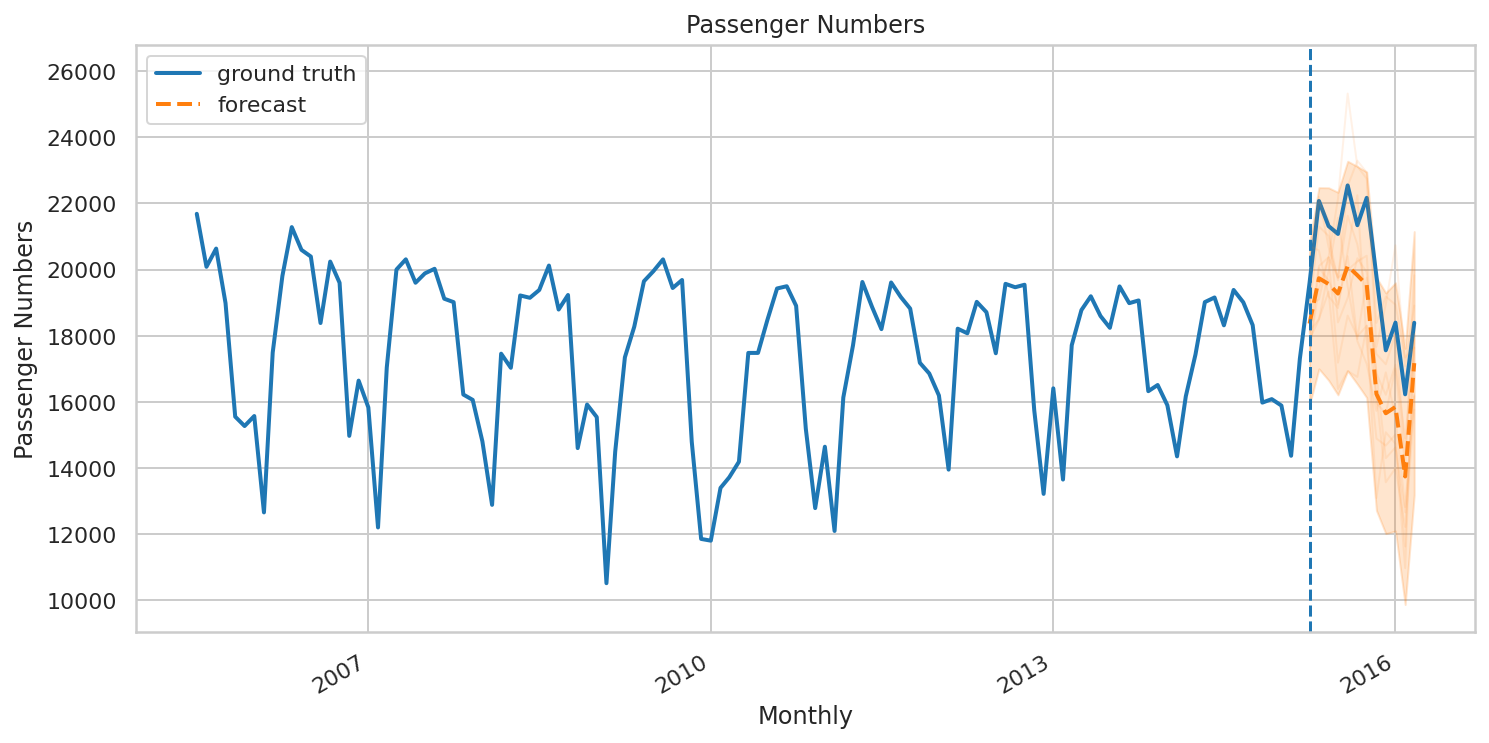

In [28]:
fig, ax = plot_forecast(
    tseries_dates, tseries,
    tseries_forecast_mean, tseries_forecast_scale, tseries_forecast_samples,
    x_locator=tseries_loc,
    x_formatter=tseries_fmt,
    title="Passenger Numbers")
ax.axvline(tseries_dates[-num_forecast_steps], linestyle="--")
ax.legend(loc="upper left")
ax.set_ylabel("Passenger Numbers")
ax.set_xlabel("Monthly")
fig.autofmt_xdate()

We can further understand the model's fit by decomposing it into the contributions of individual time series:

In [29]:
# Build a dict mapping components to distributions over
# their contribution to the observed signal.
component_dists = sts.decompose_by_component(
    tseries_model,
    observed_time_series=tseries,
    parameter_samples=q_samples_tseries_)

In [30]:
tseries_component_means_, tseries_component_stddevs_ = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()})

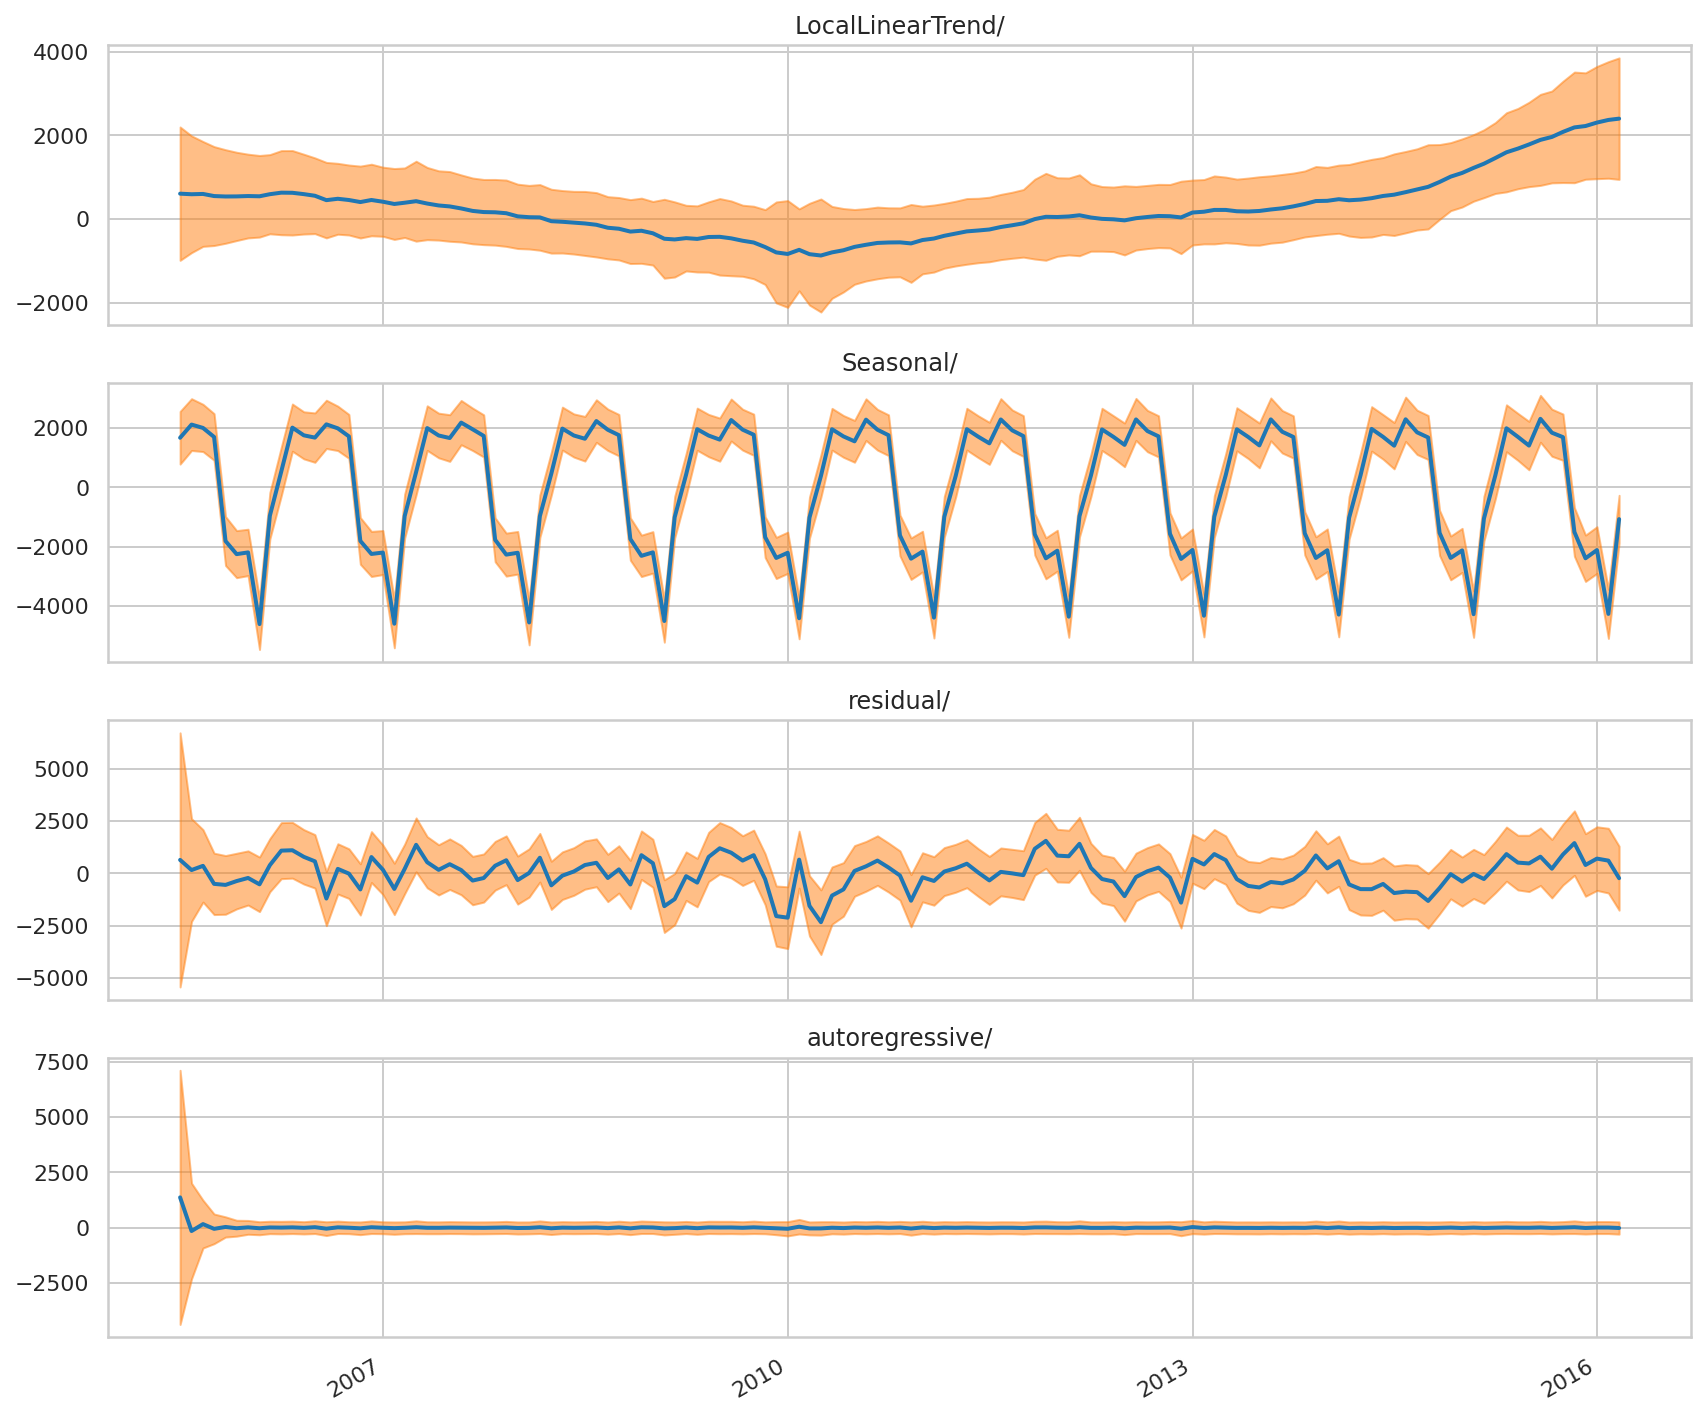

In [31]:
_ = plot_components(tseries_dates, tseries_component_means_, tseries_component_stddevs_,
                    x_locator=tseries_loc, x_formatter=tseries_fmt)

### Anomaly Detection

Anomaly detection is conducted on the basis of a one-step ahead prediction.

Anomalies are classed by means of those that lie outside 3 standard deviations. This can be modified according to the user's preference.

In [32]:
tseries_one_step_dist = sts.one_step_predictive(
    tseries_model,
    observed_time_series=tseries,
    parameter_samples=q_samples_tseries_)

tseries_one_step_mean, tseries_one_step_scale = (
    tseries_one_step_dist.mean().numpy(), tseries_one_step_dist.stddev().numpy())

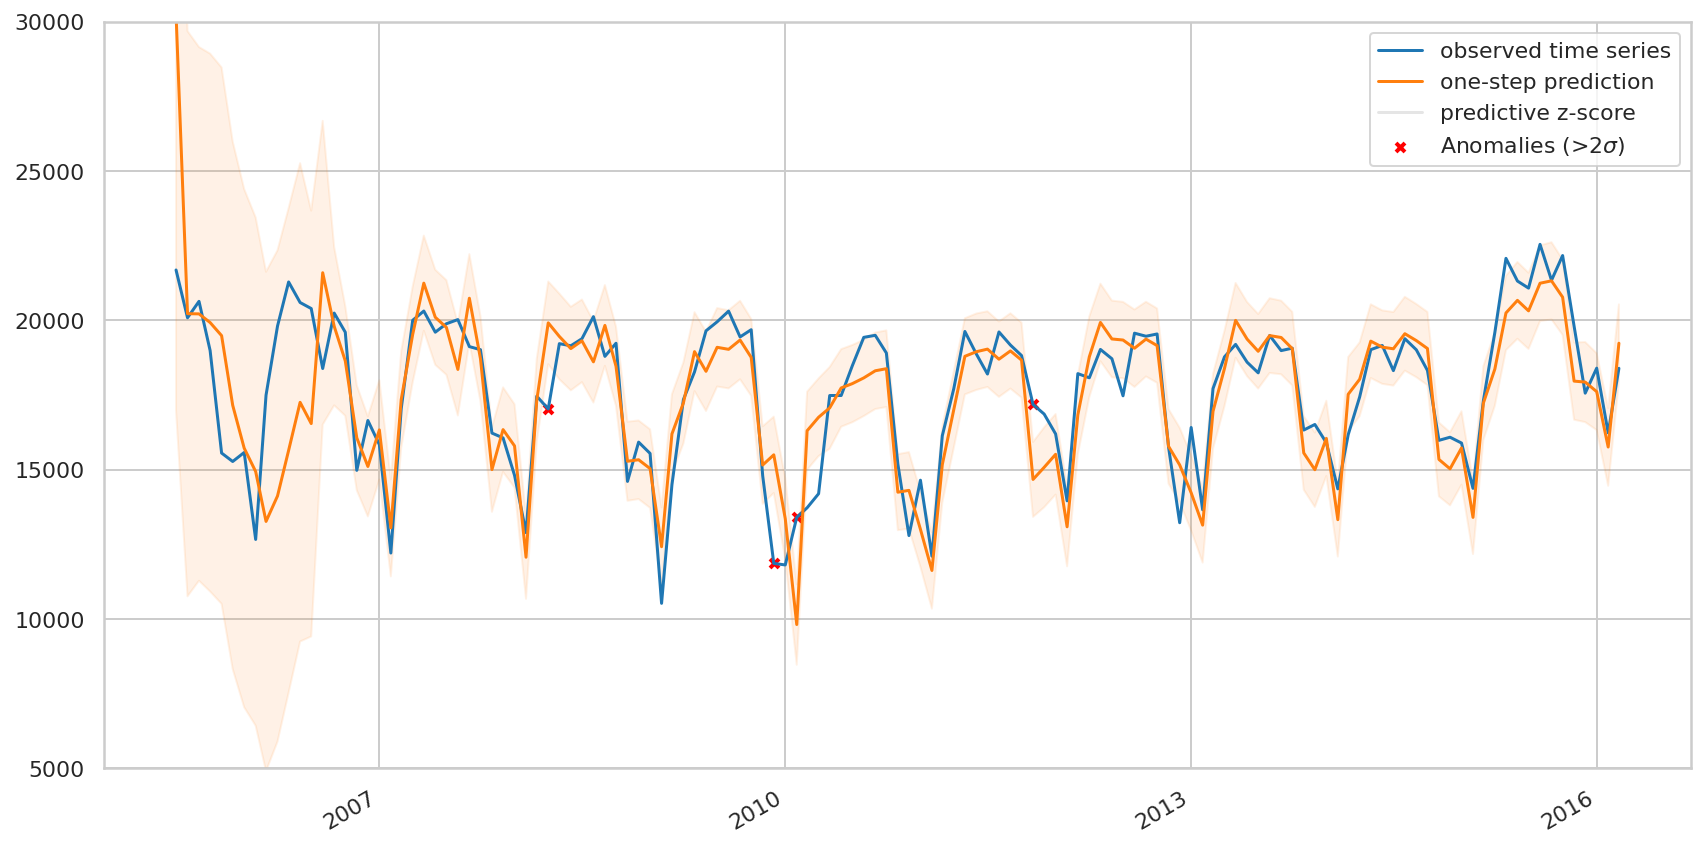

In [38]:
fig, ax = plot_one_step_predictive(
    tseries_dates, tseries,
    tseries_one_step_mean, tseries_one_step_scale,
    x_locator=tseries_loc, x_formatter=tseries_fmt)
ax.set_ylim(5000, 30000)

# Use the one-step-ahead forecasts to detect anomalous timesteps.
zscores = np.abs((tseries - tseries_one_step_mean) /
                 tseries_one_step_scale)
anomalies = zscores > 2
ax.scatter(tseries_dates[anomalies],
           tseries[anomalies],
           c="red", marker="x", s=20, linewidth=2, label=r"Anomalies (>2$\sigma$)")
ax.plot(tseries_dates, zscores, color="black", alpha=0.1, label='predictive z-score')
ax.legend()
plt.show()